In [ ]:
# default_exp core

# Actions in video

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [84]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import time
import datetime
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

from actions_in_videos.dataset_ucf101 import UCF101, SingleFrameDataset, DataLoader
from actions_in_videos.models import ResNet50Classifier
from actions_in_videos.dataset_ucf101 import BatchShower

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
%matplotlib inline

In [4]:
# save_dir = pathlib.Path('./saved-mdls/')
# save_dir.mkdir(parents=True, exist_ok=True)

In [67]:
opt = {
    'channels':3,
    'img_dim':224,
    'dataset-path': '../data/UCF101/',
    'batch-size': 4,
    'learning-rate': 0.0001,
    'num-epochs': 10,
    'checkpoint_interval': 10,
    'checkpoint-model': False
      }

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_shape = (opt['channels'], opt['img_dim'], opt['img_dim'])

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

Create the training set and its associated Dataloader:

In [47]:
# Define training set
train_ds = SingleFrameDataset(
    dataset_path=opt['dataset-path'],
    training=True,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop((224, 224)),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)
train_dl = DataLoader(train_ds, batch_size=opt['batch-size'], shuffle=True, num_workers=4)


Let's make sure that we are loading the correct stuff:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['GolfSwing'], ['PoleVault'], ['PullUps'], ['FrontCrawl']]


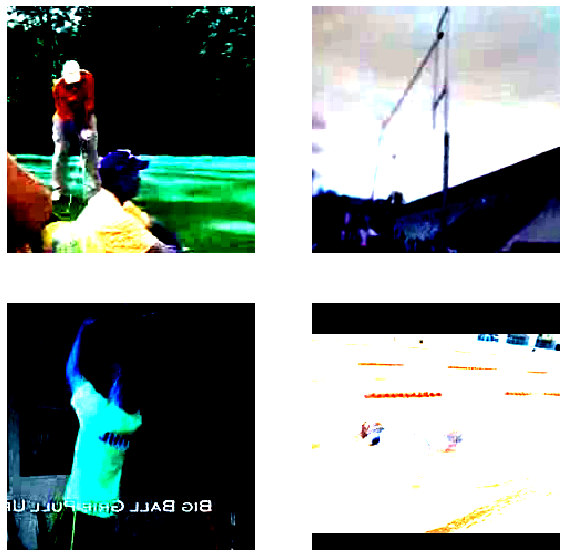

In [48]:
sb = BatchShower(train_dl)
sb.showBatch(3)

Now we create the test dataset and dataloader

In [49]:
# Define test set
test_ds = SingleFrameDataset(
    dataset_path=opt['dataset-path'],
    training=False,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((opt['img_dim'], opt['img_dim']), Image.BICUBIC), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std),
    ])
)

test_dl = DataLoader(test_ds, batch_size=opt['batch-size'], shuffle=False, num_workers=4)

We can see what it contains. Note that in this case, there is no randomness so most likely all frames will be from the same video.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['ApplyEyeMakeup'], ['ApplyEyeMakeup'], ['ApplyEyeMakeup'], ['ApplyEyeMakeup']]


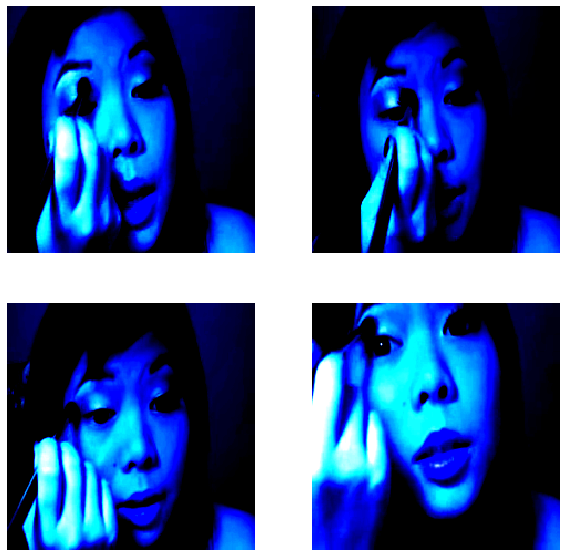

In [50]:
sb = BatchShower(test_dl)
sb.showBatch(3)

In [51]:
# Classification criterion
criterion = nn.CrossEntropyLoss().to(device)

# Define network
model = ResNet50Classifier(
    num_classes=train_ds.num_classes,
)
model = model.to(device)

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [52]:
model.feature_extractor[7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [53]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.feature_extractor[7][2].parameters():
    param.requires_grad_(True)
for param in model.final.parameters():
    param.requires_grad_(True)

In [54]:
params = []
for param in model.feature_extractor[7][2].parameters():
    params.append(param)
for param in model.final.parameters():
    params.append(param)

In [55]:
optimizer = torch.optim.Adam(params, lr=opt['learning-rate'])

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [56]:
if opt['checkpoint-model']:
    print(f"Loading checkpoint model: opt['checkpoint-model']")
    model.load_state_dict(torch.load(opt['checkpoint-model']))

In [96]:
def test_model(epoch):
    """ Evaluate the model on the test set """
    print("")
    model.eval()
    test_metrics = {"loss": [], "acc": []}
        
    for batch_i, (X, y) in enumerate(tqdm(test_dl, 'Test', leave=False)):
        image = Variable(X.to(device), requires_grad=False)
        labels = Variable(y, requires_grad=False).to(device)

        with torch.no_grad():
            # Get sequence predictions
            preds = model(image)
            
            
        print(preds.shape)
        print(labels)
        
        # Compute metrics
        acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()
        loss = criterion(preds, labels).item()
        
        # Keep track of loss and accuracy
        test_metrics["loss"].append(loss)
        test_metrics["acc"].append(acc)
        
        # Log test performance
        sys.stdout.write(
            "\rTesting -- [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
            % (
                batch_i,
                len(test_dl),
                loss,
                np.mean(test_metrics["loss"]),
                acc,
                np.mean(test_metrics["acc"]),
            )
        )    
    print("")

In [97]:
opt['num-epoch'] = 1

In [98]:
len(train_dl), len(train_dl.dataset)/opt['batch-size']

(946, 945.75)

## Training

We have now everything we need to build the training loop. This is done in the next function:

In [103]:
def train_model(model, opt, train_dl, test_dl):

    for epoch in tqdm(range(opt['num-epochs']), desc='Epoch #'):
        epoch_metrics = {"loss": [], "acc": []}
        prev_time = time.time()

        #print(f"--- Epoch {epoch} ---")
        for batch_i, (X, y) in enumerate(tqdm(train_dl, 'Train')):
            model.train()

            if X.size(0) == 1:
                continue

            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            labels = labels.squeeze()

            if len(labels.size()) == 0:
                labels = torch.tensor([labels]).to(device)

            optimizer.zero_grad()

            # Get sequence predictions
            preds = model(image_sequences)

            # Compute metrics                
            loss = criterion(preds, labels)
            acc = 100 * (preds.detach().argmax(1) == labels).cpu().numpy().mean()

            loss.backward()
            optimizer.step()

            # Keep track of epoch metrics
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)

            # Determine approximate time left
            batches_done = epoch * len(train_dl) + batch_i
            batches_left = opt['num-epochs'] * len(train_dl) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] ETA: %s"
                % (
                    epoch,
                    opt['num-epochs'],
                    batch_i,
                    len(train_dl),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    time_left,
                )
            )

            # Empty cache
    #             if torch.cuda.is_available():
    #                 torch.cuda.empty_cache()

        # Evaluate the model on the test set
        test_model(epoch)

        # Save model checkpoint
        if epoch % opt['checkpoint_interval'] == 0:
            os.makedirs('model-checkpoints', exist_ok=True)
            torch.save(model.state_dict(), f"model-checkpoints/{model.__class__.__name__}_{epoch}.pth")

In [104]:
train_model(model, opt, train_dl, test_dl)

[Epoch 0/10] [Batch 5/946] [Loss: 4.616692 (4.586857), Acc: 0.00% (4.17%)] ETA: 5:23:34.52993359

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/andreamunafo/opt/anaconda3/envs/number-five-dl/lib/python3.6/multiprocessing/connection.py", l

KeyboardInterrupt: 

In [ ]:
from nbdev.export import *
notebook2script()